In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import pickle

import chess
import chess.svg
import iceberg as ice
import numpy as np
import pandas as pd
import torch
from leela_interp import Lc0sight, LeelaBoard
from leela_interp.tools import figure_helpers as fh

In [3]:
with open("interesting_puzzles.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)

22517

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Lc0sight("lc0.onnx", device=device)

Using device: cpu


# Figure 2 (explaining puzzle)

In [5]:
# From https://github.com/revalo/iceberg/blob/main/examples/neural_network.py
class NeuralNetwork(ice.DrawableWithChild):
    layer_node_counts: tuple[int, ...]
    node_radius: float = 30
    node_vertical_gap: float = 30
    layer_gap: float = 150
    node_border_color: ice.Color = ice.Colors.WHITE
    node_fill_color: ice.Color = None
    node_border_thickness: float = 3
    line_path_style: ice.PathStyle = ice.PathStyle(ice.Colors.WHITE, thickness=3)

    def setup(self):
        # [layer_index, node_index]
        self._layer_nodes = [
            [
                ice.Ellipse(
                    rectangle=ice.Bounds(
                        top=0,
                        left=0,
                        bottom=self.node_radius * 2,
                        right=self.node_radius * 2,
                    ),
                    border_color=self.node_border_color,
                    fill_color=self.node_fill_color,
                    border_thickness=self.node_border_thickness,
                )
                for _ in range(layer_node_count)
            ]
            for layer_node_count in self.layer_node_counts
        ]

        self._node_vertical_gap = self.node_vertical_gap
        self._layer_gap = self.layer_gap
        self._line_path_style = self.line_path_style

        self._initialize_based_on_nodes()

    def _initialize_based_on_nodes(self):
        # Arrange the circles.
        nodes_arranged = ice.Arrange(
            [
                ice.Arrange(
                    circles,
                    arrange_direction=ice.Arrange.Direction.VERTICAL,
                    gap=self._node_vertical_gap,
                )
                for circles in self.layer_nodes
            ],
            arrange_direction=ice.Arrange.Direction.HORIZONTAL,
            gap=self._layer_gap,
        )

        # Draw the lines.
        self._lines = []
        for layer_a, layer_b in zip(self.layer_nodes[:-1], self.layer_nodes[1:]):
            for circle_a in layer_a:
                for circle_b in layer_b:
                    start = nodes_arranged.child_bounds(circle_a).corners[
                        ice.Corner.MIDDLE_RIGHT
                    ]
                    end = nodes_arranged.child_bounds(circle_b).corners[
                        ice.Corner.MIDDLE_LEFT
                    ]

                    line = ice.Line(start, end, self._line_path_style)
                    self._lines.append(line)

        # All the children in this composition.
        # Nodes are drawn on top of lines.
        children = self._lines
        children.append(nodes_arranged)

        self.set_child(ice.Compose(children))

    @property
    def layer_nodes(self) -> list[list[ice.Drawable | ice.Ellipse]]:
        return self._layer_nodes

In [6]:
def get_policy(board: LeelaBoard, top_k: int = 3):
    policy, wdl, _ = model.play(board, return_probs=True)
    top_moves = model.top_moves(board, policy, top_k=top_k)
    top_moves = {
        board.pc_board.san(chess.Move.from_uci(move)): prob
        for move, prob in top_moves.items()
    }
    return top_moves

In [7]:
MOVE_COLOR = fh.BEST_MOVE_COLOR + "80"
_HORIZONTAL_GAP = 25
_ARROW_PADDING = 3
_ARROW_KWARGS = {
    "line_path_style": ice.PathStyle(ice.BLACK, thickness=2),
    "head_length": 7,
}


def make_puzle_figure(puzzle: pd.Series) -> ice.Drawable:
    pv = puzzle.principal_variation

    board_plots: list[ice.Drawable] = []
    board = LeelaBoard.from_puzzle(puzzle)

    for i in range(3):
        if i == 0:
            heatmap = {pv[i][2:4]: fh.COLOR_DICT["first_target"]}
        elif i == 2:
            heatmap = {pv[i][2:4]: fh.COLOR_DICT["third_target"]}
        else:
            heatmap = None

        if i == 0:
            caption = "Initial puzzle position"
        elif i == 1:
            caption = "Position after 1st move"
        else:
            caption = "Position after 2nd move"

        board_plot = board.plot(
            arrows={pv[i]: MOVE_COLOR},
            heatmap=heatmap,
            show_lastmove=False,
        )
        board_plot += ice.Tex(tex=caption).scale(2).relative_to(board_plot, ice.UP * 10)
        board_plot = board_plot.crop(board_plot.bounds)
        new_board = board_plot

        net = (
            NeuralNetwork(
                layer_node_counts=(2, 3, 3, 2),
                node_border_color=ice.Colors.BLACK,
                node_border_thickness=6,
                line_path_style=ice.PathStyle(ice.Colors.BLACK, thickness=6),
            )
            .scale(0.2)
            .relative_to(board_plot, ice.DOWN * _HORIZONTAL_GAP)
        )
        new_board += net

        policy = get_policy(board)
        policy_plot = fh.PolicyBar(
            numbers=list(policy.values()),
            bar_labels=list(policy.keys()),
            label_font_family=fh.FONT_FAMILY,
            bar_height=150,
            ellipses=len(policy) == 3,
            use_tex=True,
            bar_width=20,
        )
        new_board += policy_plot.relative_to(new_board, ice.DOWN * _HORIZONTAL_GAP)

        with new_board:
            arrow1 = ice.Arrow(
                start=board_plot.relative_bounds.bottom_middle
                + ice.DOWN * _ARROW_PADDING,
                end=net.relative_bounds.top_middle + ice.UP * _ARROW_PADDING,
                **_ARROW_KWARGS,
            )
            arrow2 = ice.Arrow(
                start=net.relative_bounds.bottom_middle + ice.DOWN * _ARROW_PADDING,
                end=policy_plot.relative_bounds.top_middle + ice.UP * _ARROW_PADDING,
                **_ARROW_KWARGS,
            )
            new_board += arrow1
            new_board += arrow2

        board_plots.append(new_board)

        board.push_uci(pv[i])

    scene = board_plots[0]
    for board_plot in board_plots[1:]:
        scene += board_plot.relative_to(scene).move(*ice.RIGHT * 20)

    return scene.scale(2)

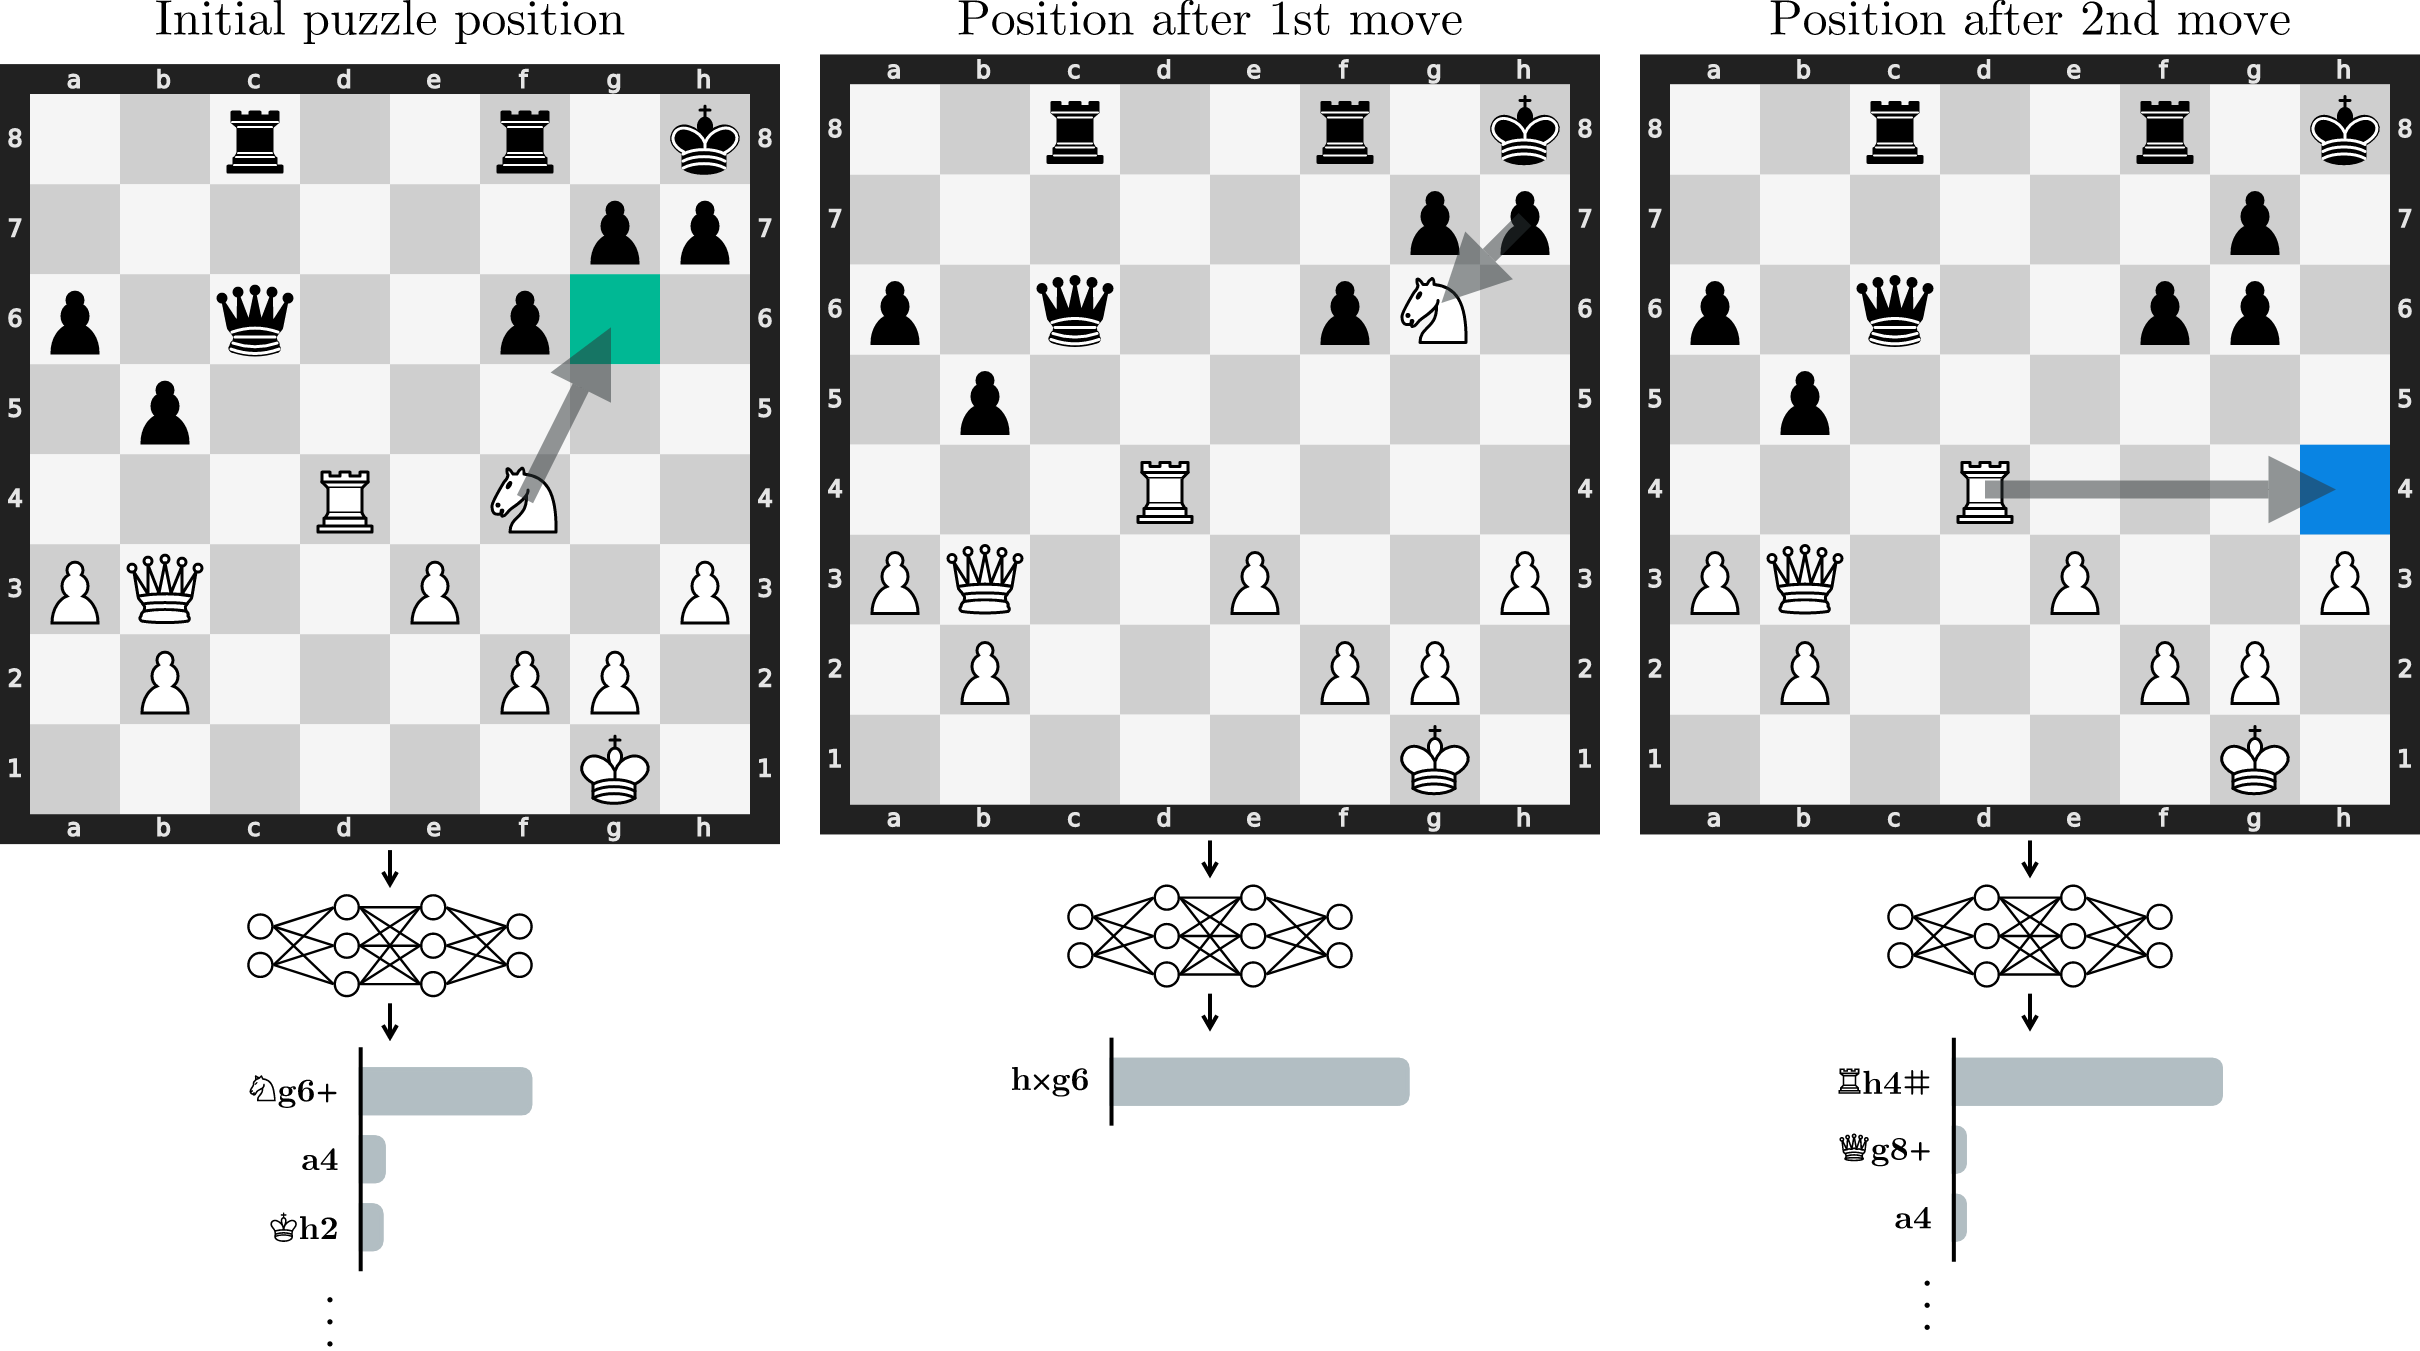

In [8]:
idx = fh.PUZZLE_LOC
# loc, not iloc!
puzzle = puzzles.loc[idx]
make_puzle_figure(puzzle)

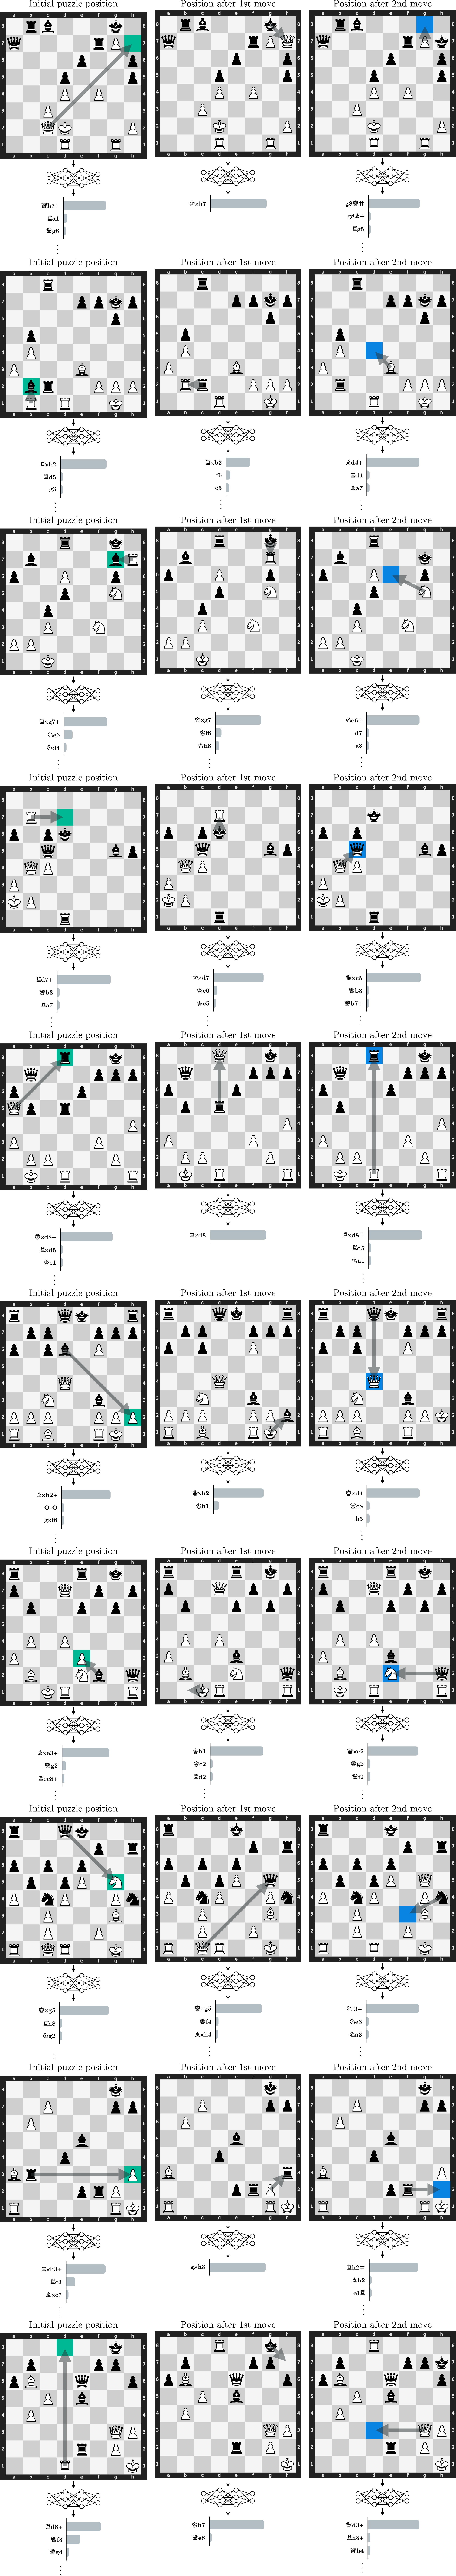

In [9]:
figures = []
for idx in range(10):
    puzzle = puzzles.iloc[idx]
    figures.append(make_puzle_figure(puzzle))

ice.Arrange(figures, arrange_direction=ice.VERTICAL, gap=20)

# Figure 1

In [10]:
def add_frame(obj, fill_color=ice.WHITE, border_radius=0.0):
    rect = ice.Rectangle(
        obj.pad(5).bounds,
        fill_color=fill_color,
        border_radius=border_radius,
    )
    return rect.add_centered(obj)

In [11]:
class Neuron(ice.DrawableWithChild):
    content: ice.Drawable
    corrupted: bool = False
    border_radius: float = 0.0
    border_color: ice.Color = ice.BLACK
    border_thickness: float = 3
    alpha: float = 1.0

    def setup(self):
        fill_color = ice.Color.from_hex("#d63031") if self.corrupted else ice.WHITE
        self.rect = fh.HatchedRectangle(
            self.content.pad(5).bounds,
            border_color=self.border_color,
            border_thickness=self.border_thickness,
            fill_color=fill_color,
            border_radius=self.border_radius,
            hatched=self.corrupted,
            hatched_thickness=4,
            hatched_angle=-45,
            hatched_spacing=15,
        )
        self.set_child(self.rect.add_centered(self.content))

In [50]:
# True is dark squares
SQUARE_COLORS = {
    True: ice.Color.from_hex("#cfcfcf"),
    False: ice.Color.from_hex("#f5f5f5"),
}


class LeelaForwardPass(ice.DrawableWithChild):
    board: LeelaBoard
    policy: dict[str, float]
    include_squares: list[str]
    input_arrow_squares: list[str]
    changed_policy: list[float] | None = None
    board_heatmap: dict[str, str] | None = None
    move_arrow: str | None = None
    board_title: str | None = None

    def setup(self):
        heatmap = self.board_heatmap or {}
        board = self.board
        ice_pieces = {}
        for piece_name, svg_text in chess.svg.PIECES.items():
            ice_pieces[piece_name] = ice.SVG(
                raw_svg=chess.svg.piece(chess.Piece.from_symbol(piece_name))
            )

        empty_piece = ice.SVG(
            raw_svg=chess.svg.piece(chess.Piece.from_symbol(piece_name))
        ).opacity(0)

        piece_array = []
        colors = []
        self.sq2idx = {}
        # reversed so that black is on top
        for square in reversed(chess.SQUARES):
            square_name = chess.SQUARE_NAMES[square]
            rank = chess.square_rank(square)
            file = chess.square_file(square)
            is_dark = (rank + file) % 2 == 0

            color = SQUARE_COLORS[is_dark]
            if square_name in heatmap:
                color = ice.Color.from_hex(heatmap[square_name])

            if square_name in self.include_squares:
                piece = board.pc_board.piece_at(square)
                self.sq2idx[square_name] = len(piece_array)

                if piece is None:
                    piece_array.append("")
                    colors.append(color)
                else:
                    piece_array.append(piece.symbol())
                    colors.append(color)
            else:
                if len(piece_array) and piece_array[-1] != "...":
                    piece_array.append("...")
                    colors.append(color)

        dots = ice.MathTex("\\vdots").scale(5)

        piece_objects = []

        for piece_name, color in zip(piece_array, colors):
            if piece_name == "":
                piece_objects.append(add_frame(empty_piece, fill_color=color))
            elif piece_name == "...":
                piece_objects.append(dots)
            else:
                piece_objects.append(
                    add_frame(ice_pieces[piece_name], fill_color=color)
                )

        tokenized_pieces = (
            ice.Arrange(piece_objects, gap=20, arrange_direction=ice.VERTICAL)
            .pad(5)
            .background(ice.WHITE)
        )

        board_arrows = {}
        if self.move_arrow:
            board_arrows[self.move_arrow] = fh.BEST_MOVE_COLOR + "80"
        ice_board = board.plot(
            heatmap=heatmap, show_lastmove=False, arrows=board_arrows
        )
        self.ice_board = ice_board
        transformed_board = ice_board.scale(1.8)
        transformed_board = transformed_board.crop(transformed_board.bounds)
        if self.board_title:
            title = ice.Text(
                self.board_title,
                ice.FontStyle("Monaco", size=40),
            ).pad(10)
            transformed_board += title.relative_to(
                transformed_board, ice.BOTTOM_MIDDLE, ice.TOP_MIDDLE
            )
        padded_ice_board = transformed_board.pad_right(150)

        scene = padded_ice_board

        scene += tokenized_pieces.relative_to(
            padded_ice_board, ice.MIDDLE_LEFT, ice.MIDDLE_RIGHT
        )

        with scene:
            i = 0
            for piece in reversed(piece_objects):
                if piece == dots:
                    continue

                square = self.include_squares[i]
                if square not in self.input_arrow_squares:
                    i += 1
                    continue

                square_rect = ice_board.square(chess.parse_square(square))
                sx, sy = square_rect.relative_bounds.corners[ice.CENTER]
                ex, ey = piece.relative_bounds.corners[ice.MIDDLE_LEFT]
                midpoint = (np.array([sx, sy]) + np.array([ex, ey])) / 2
                normal = np.array([ey - sy, sx - ex])
                # normal /= np.linalg.norm(normal)
                rank = chess.square_rank(chess.parse_square(square))
                if rank < 4:
                    normal *= -1
                path = ice.CurvedCubicLine(
                    points=[
                        (sx, sy),
                        midpoint + normal * 0.2,
                        (ex, ey),
                    ],
                    path_style=ice.PathStyle(
                        color=ice.BLACK.with_alpha(0.7), thickness=4
                    ),
                )
                arrow = ice.ArrowPath(
                    path, arrow_head_style=ice.ArrowHeadStyle.FILLED_TRIANGLE
                )
                scene += arrow
                i += 1

        if len(self.input_arrow_squares) == 0:
            with scene:
                sx, sy = transformed_board.relative_bounds.corners[ice.MIDDLE_RIGHT]
                sy -= 100
                sx += 30

                ex, ey = tokenized_pieces.relative_bounds.corners[ice.MIDDLE_LEFT]
                ex -= 30

                path = ice.CubicBezier(
                    [
                        (sx, sy),
                        (sx + 200, sy),
                        (ex - 200, ey),
                        (ex, ey),
                    ],
                    ice.PathStyle(color=ice.BLACK, thickness=4),
                )
                arrow = ice.ArrowPath(
                    path, arrow_head_style=ice.ArrowHeadStyle.FILLED_TRIANGLE
                )
                scene += arrow

        def get_neurons():
            neurons = []
            for piece_name in piece_array:
                if piece_name == "...":
                    neurons.append(dots)
                else:
                    neurons.append(Neuron(content=empty_piece, border_radius=20))
            return neurons

        initial_layers = 1
        final_layers = 3

        layers = []
        last_layer = tokenized_pieces

        for i in range(initial_layers + final_layers):
            new_neurons = get_neurons()
            layers.append(new_neurons)
            layer = (
                ice.Arrange(new_neurons, gap=20, arrange_direction=ice.VERTICAL)
                .pad(5)
                .background(ice.WHITE)
            ).pad_left(100)
            if i == initial_layers - 1:
                with layer:
                    layer = layer.next_to(
                        ice.MathTex("\\ldots").scale(5).pad_left(100), ice.RIGHT
                    )
            with scene:
                scene += layer.relative_to(last_layer, ice.TOP_LEFT, ice.TOP_RIGHT)
            last_layer = layer

        last_layer = piece_objects

        for layer_i, layer in enumerate(layers):
            if layer_i == initial_layers:
                last_layer = layer
                continue

            with scene:
                i = 0
                neurons = layer
                neuron_count = len([n for n in neurons if n != dots])
                for piece in last_layer:
                    if piece == dots:
                        continue
                    for neuron in neurons:
                        if neuron == dots:
                            continue
                        sx, sy = piece.relative_bounds.corners[ice.MIDDLE_RIGHT]
                        ex, ey = neuron.relative_bounds.corners[ice.MIDDLE_LEFT]
                        height = neuron.relative_bounds.height / 2
                        target_y = ey + height / neuron_count * i - height / 2
                        path = ice.CubicBezier(
                            [
                                (sx, sy),
                                (sx + 50, sy),
                                (ex - 50, target_y),
                                (ex, target_y),
                            ],
                            ice.PathStyle(color=ice.BLACK.with_alpha(0.3), thickness=2),
                        )
                        arrow = path
                        scene += arrow
                    i += 1
            last_layer = layer

        brace = ice.Brace(target_width=scene.bounds.height, target_height=20)
        brace = ice.Transform(child=brace, rotation=-90).pad_left(30)
        scene += brace.relative_to(scene, ice.MIDDLE_LEFT, ice.MIDDLE_RIGHT)

        policy = fh.PolicyBar(
            numbers=self.policy.values(),
            numbers_changed=self.changed_policy,
            bar_labels=self.policy.keys(),
            label_font_family=fh.FONT_FAMILY,
            bar_height=150,
            use_tex=True,
            move_scale=0.7,
        ).scale(3)

        with scene:
            scene += policy.relative_to(brace, ice.RIGHT * 30)

        self.layers = layers
        self.set_child(scene)

    def get_neuron(self, layer: int, square: str) -> Neuron:
        sq_idx = self.sq2idx[square]
        return self.layers[layer][sq_idx]

In [14]:
puzzle = puzzles.loc[fh.PUZZLE_LOC]

In [39]:
import os

os.makedirs("figures/website", exist_ok=True)
puzzle_indices = list(range(5))
for i in puzzle_indices:
    puzzle = puzzles.iloc[i]
    board = LeelaBoard.from_puzzle(puzzle)
    board.plot().render(f"figures/website/board_{i + 1}.png")

puzzle = puzzles.loc[fh.PUZZLE_LOC]
board = LeelaBoard.from_puzzle(puzzle)
board.plot().render("figures/website/board_0.png")

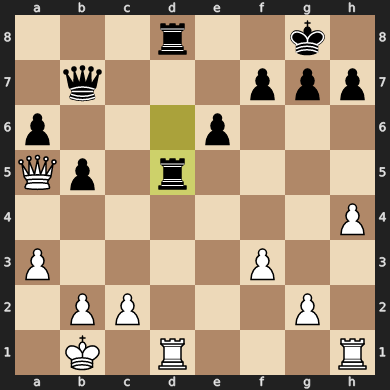

In [37]:
board.plot()

In [72]:
def make_figure_1(puzzle):
    PATCHING_SITE = (12, puzzle.principal_variation[0][2:4])

    board = LeelaBoard.from_puzzle(puzzle)

    policy, *_ = model.play(board)
    policy_dict = model.top_moves(board, policy, top_k=3)
    corrupted_board = LeelaBoard.from_fen(puzzle.corrupted_fen)
    corrupted_policy, *_ = model.play(corrupted_board)
    corrupted_policy_dict = model.top_moves(corrupted_board, corrupted_policy, top_k=3)

    sq_idx = board.sq2idx(PATCHING_SITE[1])

    layer = PATCHING_SITE[0]

    # Get corrupted activations:
    with model.trace(corrupted_board):
        corrupted_act = model.residual_stream(layer).output[0, sq_idx].save()

    # Intervention pass:
    with model.trace(board):
        model.residual_stream(layer).output[0, sq_idx] = corrupted_act
        output = model.output.save()

    intervention_policy = output[0]
    intervention_policy = model.logits_to_probs([board], intervention_policy)[0]
    intervention_policy = model.policy_as_dict(board, intervention_policy)
    intervention_probs = [intervention_policy[move] for move in policy_dict.keys()]
    policy_dict = {
        board.pc_board.san(chess.Move.from_uci(move)): prob
        for move, prob in policy_dict.items()
    }
    corrupted_policy_dict = {
        corrupted_board.pc_board.san(chess.Move.from_uci(move)): prob
        for move, prob in corrupted_policy_dict.items()
    }

    sq = PATCHING_SITE[1]
    chess_sq = chess.parse_square(sq)
    neighbors = [chess_sq - 1, chess_sq, chess_sq + 1]
    INCLUDE_SQUARES = ["a1"] + [chess.SQUARE_NAMES[sq] for sq in neighbors] + ["h8"]

    patching_squares = []
    patching_pieces = []
    for square in chess.SQUARES:
        if board.pc_board.piece_at(square) != corrupted_board.pc_board.piece_at(square):
            patching_squares.append(chess.SQUARE_NAMES[square])
            patching_pieces.append(board.pc_board.piece_at(square))

    patching_piece = None
    for piece in patching_pieces:
        if piece is not None:
            patching_piece = piece
            break

    first_target_piece = board.pc_board.piece_at(
        chess.parse_square(puzzle.principal_variation[0][2:4])
    )

    clean_pass = LeelaForwardPass(
        board=board,
        policy=policy_dict,
        changed_policy=intervention_probs,
        include_squares=INCLUDE_SQUARES,
        input_arrow_squares=[puzzle.principal_variation[0][2:4]],
        board_heatmap={
            puzzle.principal_variation[0][2:4]: fh.COLOR_DICT["first_target"]
        },
        move_arrow=puzzle.principal_variation[0],
        board_title="Clean board state",
    )

    FIGURE_PATCHING_SITE = (PATCHING_SITE[0] - 11, PATCHING_SITE[1])

    neuron = clean_pass.get_neuron(*FIGURE_PATCHING_SITE)
    neuron.corrupted = True
    neuron.border_color = ice.Color.from_hex(fh.COLOR_DICT["corrupted"])
    neuron.border_thickness = 8
    neuron.setup()

    corrupted_pass = LeelaForwardPass(
        board=corrupted_board,
        policy=corrupted_policy_dict,
        include_squares=INCLUDE_SQUARES,
        input_arrow_squares=[puzzle.principal_variation[0][2:4]],
        board_heatmap={sq: fh.COLOR_DICT["corrupted"] for sq in patching_squares},
        board_title="Corrupted board state",
    )

    for layer in corrupted_pass.layers:
        for _neuron in layer:
            _neuron.corrupted = True
            _neuron.setup()

    corruption_layer = FIGURE_PATCHING_SITE[0]
    for layer in clean_pass.layers[corruption_layer + 1 :]:
        for _neuron in layer:
            _neuron.corrupted = True
            _neuron.alpha = 0.3
            _neuron.setup()

    corrupted_neuron = corrupted_pass.get_neuron(*FIGURE_PATCHING_SITE)
    corrupted_neuron.border_color = ice.Color.from_hex(fh.COLOR_DICT["corrupted"])
    corrupted_neuron.border_thickness = 8
    corrupted_neuron.setup()

    corrupted_pass = corrupted_pass.scale(0.6)
    corrupted_pass = corrupted_pass.crop(corrupted_pass.bounds)

    scene = clean_pass
    corrupted_pass = corrupted_pass.relative_to(
        clean_pass, ice.TOP_MIDDLE, ice.BOTTOM_MIDDLE
    )
    corrupted_pass = corrupted_pass.move(-150, 100)
    scene += corrupted_pass

    with scene:
        sx, sy = corrupted_neuron.relative_bounds.corners[ice.CENTER]
        ex, ey = neuron.relative_bounds.corners[ice.CENTER]
        midpoint = (np.array([sx, sy]) + np.array([ex, ey])) / 2
        normal = np.array([ey - sy, sx - ex]) / np.linalg.norm(
            np.array([ey - sy, sx - ex])
        )
        mid_x, mid_y = tuple(midpoint + 150 * normal)
        path = ice.CurvedCubicLine(
            points=[
                (sx, sy),
                (mid_x, mid_y),
                (ex, ey),
            ],
            path_style=ice.PathStyle(color=ice.BLACK.with_alpha(0.7), thickness=6),
        )
        label = ice.Text("Patch", ice.FontStyle(size=60, family=fh.FONT_FAMILY))
        angle = np.arctan2(normal[1], normal[0]) * 180 / np.pi
        label = ice.Transform(
            child=label, rotation=angle + 90, anchor=label.bounds.corners[ice.CENTER]
        )
        label_x = mid_x - 30 * normal[0]
        label_y = mid_y - 30 * normal[1]
        label = label.move_to(label_x, label_y, ice.CENTER)
        scene += label
        arrow = ice.ArrowPath(path, arrow_head_style=ice.ArrowHeadStyle.FILLED_TRIANGLE)
        scene += arrow

    # Add the legend
    empty_square = ice.SVG(
        raw_svg=chess.svg.piece(chess.Piece.from_symbol("P"))
    ).opacity(0)

    with clean_pass.ice_board:
        best_move_start = clean_pass.ice_board.square(
            puzzle.principal_variation[0][0:2]
        ).relative_bounds.center
        best_move_end = clean_pass.ice_board.square(
            puzzle.principal_variation[0][2:4]
        ).relative_bounds.center

    best_move_start = np.array(best_move_start)
    best_move_end = np.array(best_move_end)
    angle = np.arctan2(
        best_move_end[1] - best_move_start[1], best_move_end[0] - best_move_start[0]
    )
    length = 100
    arrow_end = length * np.array([np.cos(angle), np.sin(angle)])
    best_move_arrow = ice.Arrow(
        (0, 0),
        tuple(arrow_end),
        line_path_style=ice.PathStyle(
            color=ice.Color.interpolate(
                ice.Color.from_hex(fh.BEST_MOVE_COLOR), ice.WHITE, 0.3
            ),
            thickness=16,
        ),
        arrow_head_style=ice.ArrowHeadStyle.FILLED_TRIANGLE,
    )
    best_move_arrow = ice.Rectangle(Neuron(content=empty_square).bounds).add_centered(
        best_move_arrow
    )
    legend_symbols = {
        "1st move target square": add_frame(
            ice.SVG(raw_svg=chess.svg.piece(first_target_piece))
            if first_target_piece
            else empty_square,
            fill_color=ice.Color.from_hex(fh.COLOR_DICT["first_target"]),
        ),
        "Corrupted square": add_frame(
            ice.SVG(raw_svg=chess.svg.piece(patching_piece))
            if patching_piece
            else empty_square,
            fill_color=ice.Color.from_hex(fh.COLOR_DICT["corrupted"]),
        ),
        "Clean activation": Neuron(content=empty_square, border_radius=20),
        "Corrupted activation": Neuron(
            content=empty_square, border_radius=20, corrupted=True
        ),
        "Best move": best_move_arrow,
    }
    legend_symbols = {k: v.scale(0.7).pad(5) for k, v in legend_symbols.items()}
    legend_texts = {
        text: ice.Text(
            text,
            font_style=ice.FontStyle(fh.FONT_FAMILY, size=30),
            align=ice.Text.Align.LEFT,
        )
        for text in legend_symbols
    }

    legend_symbols_and_texts = [
        ice.Arrange(
            [symbol, legend_texts[text]], gap=10, arrange_direction=ice.HORIZONTAL
        )
        for text, symbol in legend_symbols.items()
    ]

    legend_contents = legend_symbols_and_texts[0]
    for i in range(1, len(legend_symbols_and_texts)):
        legend_contents += (
            legend_symbols_and_texts[i]
            .pad_top(10)
            .relative_to(legend_contents, ice.TOP_LEFT, ice.BOTTOM_LEFT)
        )

    legend_background = ice.Rectangle(
        legend_contents.pad(10).bounds,
        border_color=ice.BLACK.with_alpha(0.1),
        fill_color=ice.BLACK.with_alpha(0.01),
        border_thickness=3,
        border_radius=10,
    )

    legend = legend_background.add_centered(legend_contents)
    scene += legend.relative_to(corrupted_pass, ice.MIDDLE_LEFT, ice.MIDDLE_RIGHT).move(
        100, 0
    )

    return scene.pad(50).background(ice.WHITE)

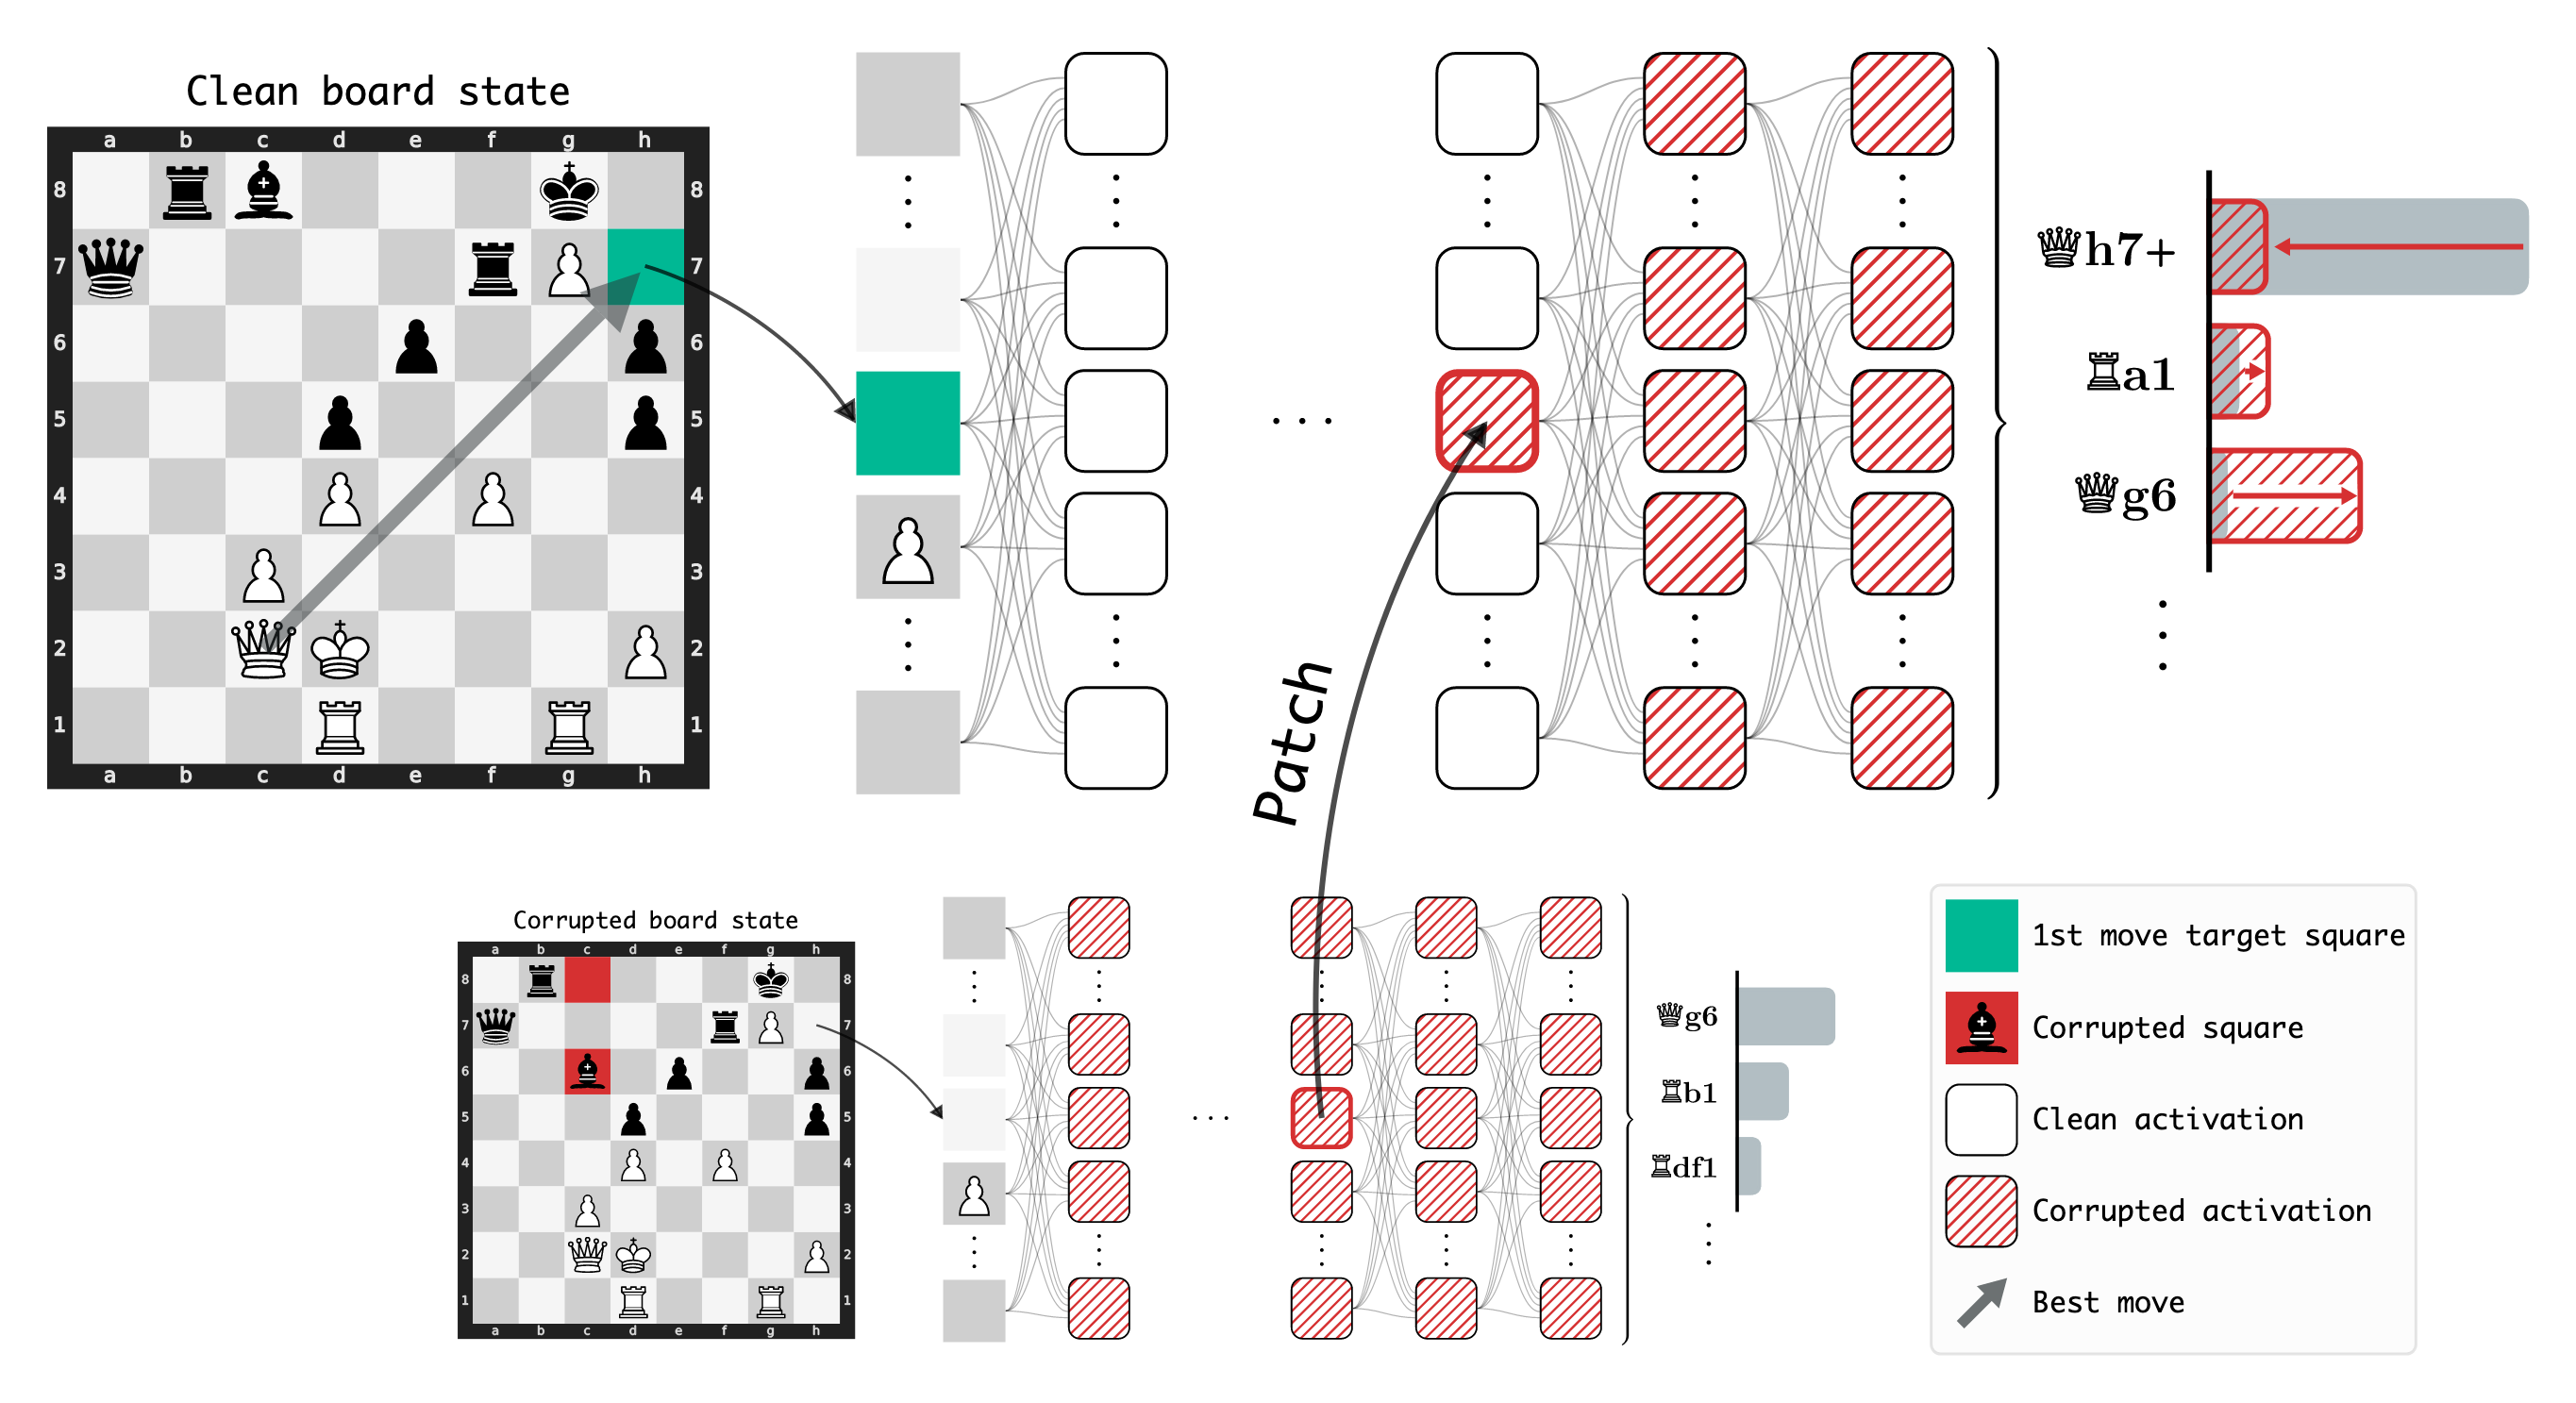

In [74]:
puzzle = puzzles.iloc[0]
make_figure_1(puzzle)